In [1]:
import grogupy
import grogupy.viz
import pickle
from temp import *


/Users/danielpozsar/Documents/studies/elte/phd/grogu/.venv/lib/python3.9/site-packages/grogupy/_tqdm.py:24: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [ ]:
simulation_kspace = grogupy.Kspace([40, 40, 40])
simulation_kspace

<grogupy.Kspace kset=[40 40 40], NK=64000>

In [3]:
simulation_contour = grogupy.Contour(
    eset=42,
    esetp=10000,
    emin=-90,
    emax=-0.060516357421875000,
    emin_shift=0,
    emax_shift=0,
)
simulation_contour


<grogupy.Contour emin=-90, emax=-0.060516357421875, eset=42, esetp=10000>

In [4]:
with open("/Users/danielpozsar/Downloads/pakk 1/fake_dh.pkl", "rb") as f:
    dh = pickle.load(f)
dh
dh.H.shape


(2, 89, 14, 14)

In [5]:
simulation_hamiltonian = grogupy.Hamiltonian(
    (dh, dh),
    [0, 0, 1],
)
simulation_hamiltonian


Exception: ('Not valid input:', (<class 'temp.FakeSislHamiltonian'>, <class 'temp.FakeSislHamiltonian'>))

In [ ]:
simulation = grogupy.Builder([[1,0,0], [0,1,0], [0,0,1]])

simulation.add_kspace(simulation_kspace)
simulation.add_contour(simulation_contour)
simulation.add_hamiltonian(simulation_hamiltonian)


# cutoff of 1
# simulation.add_magnetic_entities({'orb': [1,3,4,5,9,10,11,12,13]})
#cutoff of 1.1
#simulation.add_magnetic_entities({'orb': [3,4,5,9,10,11,12,13]})
#cutoff of 1.3
#simulation.add_magnetic_entities({'orb': [3,4,5,11,12,13]})
#cutoff of 1.4
#simulation.add_magnetic_entities({'orb': [3,4,5]})
#cutoff of d
#simulation.add_magnetic_entities({'orb': [9,10,11,12,13]})
#cutoff other
simulation.add_magnetic_entities({'orb': [9,10,11,12,13]})
"""
    1   Fe          Up spin      Down spin     Sum           Diff
            multiple
  s           0    0.274652013  0.336506030   0.611158043  -0.061854016
  s           1    0.536600152  0.552353618   1.088953770  -0.015753466
  s           2    0.015548454  0.016039910   0.031588364  -0.000491456
  px          0    0.953035813  0.953136359   1.906172172  -0.000100546
  py          0    0.953035812  0.953136357   1.906172169  -0.000100545
  pz          0    0.953035839  0.953136386   1.906172226  -0.000100547
  px          1    0.300363456  0.362262515   0.662625971  -0.061899059
  py          1    0.300363753  0.362262738   0.662626491  -0.061898986
  pz          1    0.300363597  0.362262758   0.662626355  -0.061899160
  d3z^2-r^2   0    0.911136417  0.316873955   1.228010372   0.594262462
  dx^2-y^2    0    0.911136252  0.316874001   1.228010253   0.594262251
  dxy         0    0.861836733  0.506791271   1.368628004   0.355045463
  dxz         0    0.861836986  0.506790963   1.368627949   0.355046023
  dyz         0    0.861836738  0.506791124   1.368627862   0.355045615
"""
pairs = []
for c in simulation._dh.sc_off:
    pairs.append(dict(ai=0, aj=0, Ruc=c))
simulation.add_pairs(pairs)

dist = []
for p in simulation.pairs:
    dist.append(p.distance)
dist = np.array(dist)

uniques = np.unique(dist)
new_sc_off = []
for u in uniques:
    idx = np.where(u == dist)[0][0]
    new_sc_off.append(simulation._dh.sc_off[idx])

simulation.pairs = []
pairs = []
for c in new_sc_off:
    if np.allclose(c, [0,0,0]):
        continue
    pairs.append(dict(ai=0, aj=0, Ruc=c))
simulation.add_pairs(pairs)


Add pairs:: 100%|██████████| 7/7 [00:00<00:00, 15802.01it/s]


In [ ]:
simulation.solve()

Parallel over k on CPU0:: 100%|██████████| 64000/64000 [11:16<00:00, 94.67it/s] 
/Users/danielpozsar/Documents/oktatás/elte/phd/grogu/.venv/lib/python3.9/site-packages/grogupy/physics/utilities.py:375: UserWarning: This is experimenal!
  warnings.warn("This is experimenal!")
/Users/danielpozsar/Documents/oktatás/elte/phd/grogu/.venv/lib/python3.9/site-packages/grogupy/physics/utilities.py:517: UserWarning: This is experimenal!
  warnings.warn("This is experimenal!")


In [ ]:
print(simulation.to_magnopy())


# ================================================================================
# grogupy version: 0.0.6
# Input file: Unknown!
# Spin mode: POLARIZED
# ================================================================================
# SLURM job ID: Could not be determined.
# Architecture: CPU
# Number of nodes in the parallel cluster: 1
# Parallelization is over: K
# Solver used for Greens function calculation: Sequential
# Solver used for Exchange tensor: Fit
# Solver used for Anisotropy tensor: Fit
# ================================================================================
# Cell [Ang]:
# -1.432999896834187270e+00 1.432999896834187270e+00 1.432999896834187270e+00
# 1.432999896834187270e+00 -1.432999896834187270e+00 1.432999896834187270e+00
# 1.432999896834187270e+00 1.432999896834187270e+00 -1.432999896834187270e+00
# ================================================================================
# DFT axis: [0 0 1]
# Quantization axis and perpendicular rotation direction

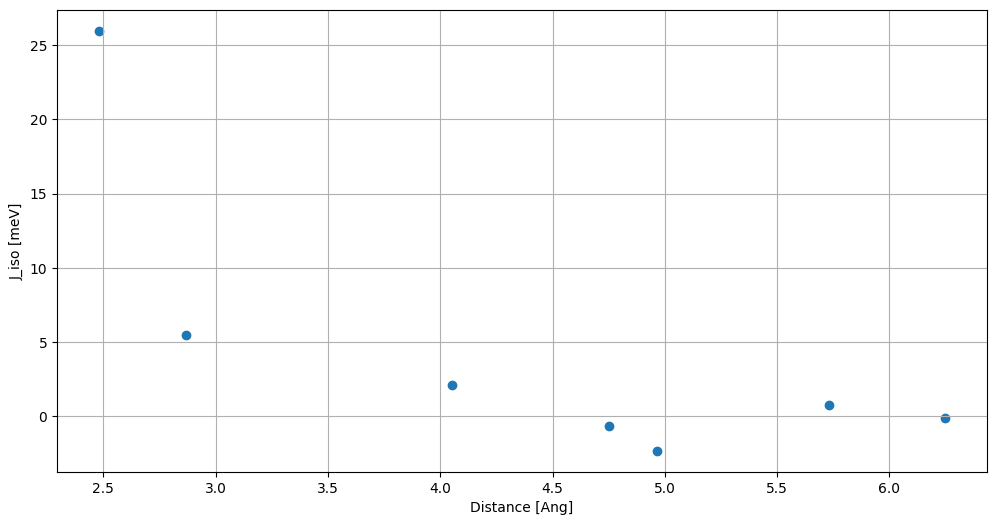

In [ ]:
iso = []
dist = []
for p in simulation.pairs:
    dist.append(p.distance)
    iso.append(p.J_iso_meV)
iso = np.array(iso) / -2
dist = np.array(dist)


import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.scatter(dist, iso)
plt.ylabel("J_iso [meV]")
plt.xlabel("Distance [Ang]")
plt.grid()

In [ ]:
simulation.magnetic_entities[0]._orbital_box_indices

array([ 9, 10, 11, 12, 13])

In [ ]:
# saved cutoff_d_orbs
#np.save("openmx.npy", np.vstack((dist, iso)).T)